<a name="Contents"></a>  

# Table of Contents
* <a href="#libs">Libraries</a>  
* <a href="#funs">Functions</a>  
    * <a href="#geojson">Coordinates to GeoJSON</a>  
    * <a href="#gee">GEE Retriever and merging</a>  
        * <a href="#sigmavv">Sigma Retriever</a>  
        * <a href="#gpm">IMERG Retriever</a>  
        * <a href="#merger">Merge RS products</a>  
        * <a href="#sigma2rain">Sigma2Rain</a>  
    * <a href="#plt">Plotting</a>  
        * <a href="#1:1 plot">1:1 Plot</a>  
        * <a href="#Interactive map">Interactive map</a>  
* <a href="#import">Read data</a>  
* <a href="#preprocess">Prepare data</a>  
* <a href="#val">Validation of Sigma2Rain</a>  
* <a href="#res1">Regression Model results</a>
* <a href="#res2">Classification Model results</a> 
* <a href="#res3">Results of Machine learning models</a>  
* <a href="#sigma2rain_simple">Sigma2Rain at specific dates and location</a>  
* <a href="#sigma2rain_all">Sigma2Rain for specific dates at the whole Ghana</a>  
* <a href="#vis">Interactive visualization</a>  


<a name="libs"></a>  
<a href="#Contents">Back to Contents</a>

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import sklearn
import scipy
import ee
import time
import warnings
from tqdm import tqdm
from ipywidgets import interact, widgets
import pickle

import geopandas
from shapely.geometry import Polygon
from cartopy.io import shapereader
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from sklearn import metrics as mt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, RandomForestRegressor, StackingRegressor, VotingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC, SVR

warnings.filterwarnings("ignore")

ee.Initialize()

<a name="funs"></a>  
<a href="#Contents">Back to Contents</a>

# Functions

<a name="geojson"></a>  
<a href="#Contents">Back to Contents</a>

## Coordinates to GeoJSON

In [2]:
def p2r(point, area_size = 100, field_size = 20):
    dist_lat = abs(area_size / 110.540)/1000
    dist_lon = abs(area_size / (111.320 * np.cos(point[0])))/1000
    area = {"type": "FeatureCollection", "features": [{"type": "Feature", "properties": {},"geometry": {"type": "Polygon", "coordinates": [[[point[0] - dist_lon/2, point[1] - dist_lat/2], [point[0] + dist_lon/2, point[1] - dist_lat/2], [point[0] + dist_lon/2, point[1] + dist_lat/2], [point[0] - dist_lon/2, point[1] + dist_lat/2], [point[0] - dist_lon/2, point[1] - dist_lat/2]]]}}]}
    coords_area = area['features'][0]['geometry']['coordinates']
    aoi_area = ee.Geometry.Polygon(coords_area)
    dist_lat = abs(field_size / 110.540)/1000
    dist_lon = abs(field_size / (111.320 * np.cos(point[0])))/1000 
    soccer={"type": "FeatureCollection", "features": [{"type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[point[0] - dist_lon/2, point[1] - dist_lat/2], [point[0] + dist_lon/2, point[1] - dist_lat/2], [point[0] + dist_lon/2, point[1] + dist_lat/2], [point[0] - dist_lon/2,point[1] + dist_lat/2], [point[0] - dist_lon/2, point[1] - dist_lat/2]]]}}]}
    coords_soccer = soccer['features'][0]['geometry']['coordinates']
    aoi_soccer = ee.Geometry.Polygon(coords_soccer)
    return(aoi_area, aoi_soccer)

<a name="gee"></a>  
<a href="#Contents">Back to Contents</a>

## GEE Retriever and merging

<a name="sigmavv"></a>  
<a href="#Contents">Back to Contents</a>
### Sentinel-1 Retriever

In [3]:
def SigmaVV(date_start, date_stop, area, patch, dist, instrumentMode = 'IW', band2 = 'VV'):
    patch = patch.buffer(dist)
    im_coll = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT') # Select the image collection from the Google Earth Engine
                .filterBounds(area) # Limit the area
                .filterDate(ee.Date(date_start),ee.Date(date_stop)) # Select specific dates
                .filter(ee.Filter.eq('instrumentMode', instrumentMode)) # Select instrument (IW)
                .sort('system:time_start') # Sort the results by dates
                .select([band2, 'angle'])) # Select only the wanted band
    
    acq_times = im_coll.aggregate_array('system:time_start').getInfo() # Retrieve the list of dates
    avalaible_dates = [time.strftime('%x', time.gmtime(acq_time/1000)) for acq_time in acq_times] # Change them to wanted format
    im_list = im_coll.toList(im_coll.size()) # Put the image collection to list
    
    SigmaVV_list = ee.List([])
    SigmaVV_list_VAR = ee.List([])
    
    def reduce_dataset_region(image, list):
        local_image = image.reduceRegion(ee.Reducer.median(), patch) # Get the median value of the field
        return ee.List(list).add(local_image) # Add value to list
    
    def reduce_dataset_region_VAR(image, list):
        local_image = image.select(band2).reduceRegion(ee.Reducer.variance(), patch) # Get the median value of the field
        return ee.List(list).add(local_image) # Add value to list
    
    reduced_dataset = im_coll.iterate(reduce_dataset_region, SigmaVV_list)
    reduced_dataset_VAR = im_coll.iterate(reduce_dataset_region_VAR, SigmaVV_list_VAR)

    reduced_dataset_dict = reduced_dataset.getInfo()
    reduced_dataset_dict_VAR = reduced_dataset_VAR.getInfo()
    
    df1 = pd.DataFrame(data = reduced_dataset_dict, index = avalaible_dates, columns = [band2, 'angle'])
    df2 = pd.DataFrame(reduced_dataset_dict_VAR)
    df1['Var_VV'] = df2.values
    df1 = df1.dropna()
    df1.index = pd.to_datetime(df1.index)
    df1 = df1.groupby(df1.index, as_index=True).mean()
    df1['VV_db'] = 10 * np.log10(df1['VV'])
    df1['VV_var_db'] = 10 * np.log10(df1['Var_VV'])
    df1 = df1[['angle', 'VV_db', 'VV_var_db']]
    return df1

<a name="gpm"></a>  
<a href="#Contents">Back to Contents</a>

### GPM/IMERG Retriever

In [4]:
def rain(date_start, date_stop, area, patch):
    band2 = 'precipitationCal'
    im_coll = dataset = ee.ImageCollection("NASA/GPM_L3/IMERG_V06")\
                        .filterBounds(area)\
                        .filterDate(ee.Date(date_start),ee.Date(date_stop))\
                        .select(band2)

    acq_times = im_coll.aggregate_array('system:time_start').getInfo()
    avalaible_dates = [time.strftime('%x', time.gmtime(acq_time/1000)) for acq_time in acq_times]
    im_list = im_coll.toList(im_coll.size())
    
    variable_list = ee.List([])
   
    def reduce_dataset_region(image, list):
        local_image = image.reduceRegion(
            reducer=ee.Reducer.median(),
            geometry=patch,
            scale=1,
            crs = "epsg:4326")

        return ee.List(list).add(local_image)
    
    reduced_dataset = im_coll.iterate(reduce_dataset_region, variable_list)
    reduced_dataset_dict = reduced_dataset.getInfo()
    df1 = pd.DataFrame(data = reduced_dataset_dict, index = avalaible_dates, columns = [band2]).dropna()
    df1.index = pd.to_datetime(df1.index)
    GPM_r = df1.resample('D').mean() * 24
    GPM_r.columns = ['GPM']
    return GPM_r

<a name="merger"></a>  
<a href="#Contents">Back to Contents</a>

### Merge SIGMA & IMERG data

In [5]:
def merge_rain_sigma(sigma, rainIMERG):
    rescale = sigma.index[1] - sigma.index[0]
    index0 = sigma.index[0]
    index1 = sigma.index[1]
    dt = float(str(rescale).split()[0])
    if sigma.index[1] - sigma.index[0] == pd.to_timedelta('1 days 00:00:00'):
        sigma['VV_db2'] = sigma['VV_db'].shift(-2)
        sigma['VV_var_db2'] = sigma['VV_var_db'].shift(-2)
    else:
        sigma['VV_db2'] = sigma['VV_db'].shift(-1)
        sigma['VV_var_db2'] = sigma['VV_var_db'].shift(-1)
    sigma = sigma.dropna()
    
    merged_df = sigma.copy()
    if dt == 6:
        merged_df['GPM'] = rainIMERG.loc[index0:].resample('6D').sum()
    else:
        precA = rainIMERG.loc[index0:].resample('6D').sum()
        precB = rainIMERG.loc[index1:].resample('6D').sum()
        p6d = precA.append(precB)
        p6d = p6d.sort_index(ascending=True)
        merged_df['GPM'] = p6d
    merged_df = merged_df[['angle', 'VV_db', 'VV_db2', 'VV_var_db', 'VV_var_db2', 'GPM']]
    return merged_df

<a name="sigma2rain"></a>  
<a href="#Contents">Back to Contents</a>

### Sigma2Rain

In [6]:
def sigma2rain(cords, date_start, date_stop, classifier, regressor):
    aoi_area, aoi_soccer = p2r(cords, area_size = 1000, field_size = 20)
    sigma = SigmaVV(date_start, date_stop, aoi_area, aoi_soccer, 1)
    rainIMERG = rain(date_start, date_stop, aoi_area, aoi_soccer)
    rainfall_prediction = merge_rain_sigma(sigma, rainIMERG)

    rainfall_prediction_class = rainfall_prediction.copy()
    y_pred = classifier.predict(rainfall_prediction_class.values)
    y_prob = classifier.predict_proba(rainfall_prediction_class.values)

    y_pred_reg = regressor.predict(rainfall_prediction.values)

    results = pd.DataFrame(y_pred, columns = ['Rain/No Rain'])
    results['Probability of Rain'] = np.round(y_prob[:, 1], 2)
    results['Estimated rainfall'] = np.round(y_pred_reg, 2)
    results['Estimated rainfall'][results['Probability of Rain'] < 0.5] = 0
    results['GPM'] = np.round(rainfall_prediction['GPM'].values)
    results[['GPM', 'Rain/No Rain', 'Probability of Rain', 'Estimated rainfall']].round(2)
    results.index = rainfall_prediction.index
    results['Lon'], results['Lat'] = list(cords)
    return results

<a name="plt"></a>  
<a href="#Contents">Back to Contents</a>  

## Plotting

<a name="1:1 plot"></a>  

### 1:1 Plotting

In [7]:
def plot_regression_stats(O, P, statistics = True):
    # Calculate stats of O, P
    mae = sklearn.metrics.mean_absolute_error(O, P)
    mse = sklearn.metrics.mean_squared_error(O, P)
    rmse = np.sqrt(mse)
    mape_in = pd.DataFrame(np.abs((O - P) / (O))).replace([np.inf, -np.inf], np.nan)
    mape = np.nanmean(mape_in.values) * 100
    RSq = sklearn.metrics.r2_score(O, P)
    r2 = scipy.stats.pearsonr(O, P)[0]**2
    nse = (1-(np.sum((P-O)**2)/np.sum((O-np.mean(O))**2)))
    
    # Plot scatter
    plt.figure(figsize = (6, 6))
    plt.scatter(O, P, edgecolor='#808080', facecolors='#C0C0C0', linewidth=1, zorder = 2)
    corr, _ = scipy.stats.pearsonr(O, P) # Pearson correlation between observed and predicted
    regmodel = LinearRegression() # Apply linear regression best fit between observed and predicted
    regmodel.fit(O.reshape(-1,1), P)
    rsq = regmodel.score(O.reshape(-1,1), P)
    obs, pred = O.reshape(-1,1), regmodel.predict(O.reshape(-1,1))
    plt.plot([obs.min(), obs.max()], [pred.min(), pred.max()], color = 'black', lw = 3, zorder = 3)
    plt.plot([0, np.max([O, P]) + 1], [0, np.max([O, P]) + 1], 'r--', zorder = 4)
    plt.xlabel('VV [db]')
    plt.ylabel('Precipitation[mm/6d]')
    
    if statistics:
        # Add stats on the plot
        stats = np.round([mae, mse, rmse, mape, RSq, r2], 3)
        stats = pd.DataFrame(data = stats, index = ['MAE', 'MSE', 'RMSE', 'MAPE', 'RSq', u'R\u00b2'], columns = ['Metrics'])
        stats.loc['RSq'] = np.round((stats.loc['RSq']* 100) , 2)
        stats.loc[u'R\u00b2'] = np.round((stats.loc[u'R\u00b2']* 100) , 2) 
        stats2 = pd.DataFrame(stats['Metrics'][:3].astype(str) + ' mm' )
        stats3 = pd.DataFrame(stats['Metrics'][3:].astype(str) + ' %' )
        stats = stats2.append(stats3)
        table = plt.table(cellText=stats.values, colWidths = [0.5] * len(stats.columns),
              rowLabels = stats.index, cellLoc = 'left', rowLoc = 'left', loc = 4, edges='open') # Adjust table size loc and allignment
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(.5, 1.5)
    plt.legend([u'Pearson R\u00b2: {:.3f} &\nPearson R: {:.3f}'.format(corr**2, corr), '1:1 Plot', 'Observed - Predicted'], loc = 2)

<a name="Interactive map"></a>  
<a href="#Contents">Back to Contents</a>

### Plot interactive map

In [8]:
def plot_date(Date, rain_no_rain = True):
    for_plot = ghana_monthly[(ghana_monthly.index == Date)]

    resolution = '10m'
    category = 'cultural'
    name = 'admin_0_countries'

    shpfilename = shapereader.natural_earth(resolution, category, name)
    df = geopandas.read_file(shpfilename)
    poly = [df.loc[df['ADMIN'] == 'Ghana']['geometry'].values[0]]

    stamen_terrain = cimgt.Stamen('terrain-background')
    ll_proj = ccrs.PlateCarree()

    cmap = 'coolwarm_r'
    cmap_ = cm.get_cmap(cmap, 2)
    rgbs = []
    for i in range(cmap_.N):
        rgb = cmap_(i)[:3]
        rgbs.append(matplotlib.colors.rgb2hex(rgb))

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1, projection=ll_proj)
    ax.add_geometries(poly, crs=ll_proj, facecolor='none', edgecolor='black')
    if rain_no_rain:
        im = ax.scatter(for_plot['Lon'], for_plot['Lat'], marker = 'p', cmap = cmap, c = for_plot['Rain/No Rain'], s = 60, zorder = 100, vmin = 0, vmax = 1)
        plt.scatter(0, 0, c = '{}'.format(rgbs[-1]), label = 'rain')
        plt.scatter(0, 0, c  = '{}'.format(rgbs[0]), label = 'no rain')
    else:
        im = ax.scatter(for_plot['Lon'], for_plot['Lat'], marker = 'p', cmap = cmap, c = for_plot['Estimated rainfall'], s = 60, zorder = 100)

    pad1 = 1
    exts = [poly[0].bounds[0] - pad1, poly[0].bounds[2] + pad1, poly[0].bounds[1] - pad1, poly[0].bounds[3] + pad1];
    ax.set_extent(exts, crs=ll_proj)
    gl = ax.gridlines(draw_labels=True, color = 'black', ls = '--', alpha = 0.3)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    plt.title('{} - {}'.format(((str(for_plot.index.min())).split()[0]), (str(for_plot.index.min() + pd.to_timedelta('6 days 00:00:00')).split()[0])))
    if rain_no_rain:
#         plt.colorbar(im, ax=ax)
        plt.legend()
    else:
        plt.colorbar(im, ax=ax)
    plt.ylim(4, 12);

<a name="read"></a>  
<a href="#Contents">Back to Contents</a>

# Read data

In [9]:
TAHMO_stations = pd.read_excel('TAHMO_Soccer Fields.xlsx', index_col = 0)
all_data = pd.read_csv('training_data.csv', index_col = 0, parse_dates = True)

classifier = pickle.load(open('classifier.sav', 'rb'))
regressor = pickle.load(open('regressor.sav', 'rb'))

<a name="preprocess"></a>  
<a href="#Contents">Back to Contents</a>

# Prepare data

### Read data and split it by 70%-30%

In [10]:
X = all_data[['angle', 'VV_db', 'VV_db2', 'VV_var_db', 'VV_var_db2', 'GPM']].values
y = all_data[['P6d']].values.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle = True, random_state=123)

### Add a threshold of rain and remove the observations that are lower:
$$P_{thresh} = 5mm/6d$$ 

In [11]:
threshold = 5

GPM_class = np.where(X_test[:, -1] >= 5, 1, 0)
y_train_class = np.where(y_train >= 5, 1, 0)
y_test_class = np.where(y_test >= 5, 1, 0)

<a name="val"></a>  
<a href="#Contents">Back to Contents</a>

# Validation of Sigma2Rain predictions

<a name="res1"></a>  

## Classification Model results

In [12]:
y_pred = classifier.predict(X_test)
y_prob = classifier.predict_proba(X_test)

print('Classification Score of Sigma2Rain: {}, Classification score of GPM {}'.format(np.round(mt.f1_score(y_pred, y_test_class), 3), np.round(mt.f1_score(y_pred, GPM_class), 3)))

Classification Score of Sigma2Rain: 0.957, Classification score of GPM 0.832


<a name="res2"></a>  
<a href="#Contents">Back to Contents</a>

## Regression Model results

In [13]:
y_pred_reg = regressor.predict(X_test)

print('Pearson correlation of Sigma2Rain: {}, Pearson correlation of GPM {}'.format(np.round(scipy.stats.pearsonr(y_pred_reg, y_test)[0]**2, 3), np.round(scipy.stats.pearsonr(X_test[:, -1], y_test)[0]**2, 3)))

Pearson correlation of Sigma2Rain: 0.684, Pearson correlation of GPM 0.333


<a name="res3"></a>  
<a href="#Contents">Back to Contents</a>

# Visualization of the validation of Regression Sigma2Rain and IMERG model

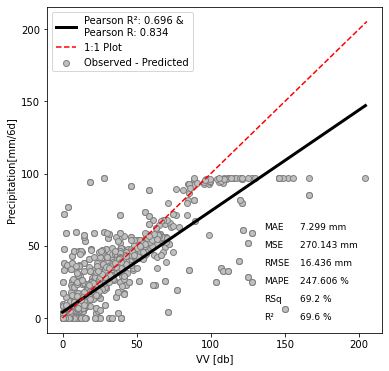

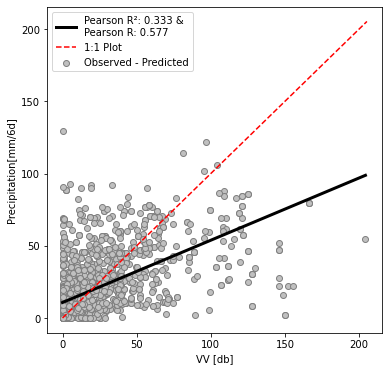

In [14]:
results = pd.DataFrame(y_pred, columns = ['Rain/No Rain'])
results['Probability of Rain'] = np.round(y_prob[:, 1], 2)
results['Estimated rainfall'] = y_pred_reg
results['Estimated rainfall'][results['Probability of Rain'] < 0.5] = 0
results['GPM'] = X_test[:, -1]
results['Observed rainfall'] = y_test
results = results[['GPM', 'Observed rainfall', 'Rain/No Rain', 'Probability of Rain', 'Estimated rainfall']].round(2)

plot_regression_stats(results['Observed rainfall'].values, results['Estimated rainfall'].values, statistics = True)
plot_regression_stats(results['Observed rainfall'].values, results['GPM'].values, statistics = False)

<a name="sigma2rain_simple"></a>  
<a href="#Contents">Back to Contents</a>

# Sigma2Rain at specific dates and location

In [15]:
date_start = '2021-08-01'
date_stop = '2021-09-01'
field = 'a23'

sigma2rain(TAHMO_stations.loc[field], date_start, date_stop, classifier, regressor)

,Rain/No Rain,Probability of Rain,Estimated rainfall,GPM,Lon,Lat
2021-08-02,1,0.83,23.74,44.0,-2.4308,9.4909
2021-08-03,1,0.97,47.30,67.0,-2.4308,9.4909
2021-08-08,1,0.94,43.25,64.0,-2.4308,9.4909
2021-08-09,1,0.95,46.20,41.0,-2.4308,9.4909
2021-08-14,1,0.89,39.84,10.0,-2.4308,9.4909
2021-08-15,1,0.94,23.77,12.0,-2.4308,9.4909
2021-08-20,1,0.93,58.63,83.0,-2.4308,9.4909
2021-08-21,1,0.99,73.48,84.0,-2.4308,9.4909


<a name="sigma2rain_all"></a>  
<a href="#Contents">Back to Contents</a>

# Sigma2Rain for specific dates at the whole Ghana 

In [16]:
ghana_monthly = pd.DataFrame()

date_start = '2021-07-01'
date_stop = '2021-09-01'

for i in tqdm(range(len(TAHMO_stations))):
    results = sigma2rain(list(TAHMO_stations.iloc[i]), date_start, date_stop, classifier, regressor)
    ghana_monthly = ghana_monthly.append(results)
    
av_dates = []
for i in range(len(np.unique(ghana_monthly.index))):
    av_dates.append(str(pd.to_datetime(np.unique(ghana_monthly.index)[i])).split()[0])

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [12:56<00:00, 15.84s/it]


<a name="vis"></a>  
<a href="#Contents">Back to Contents</a>

# Interactive visualization

In [17]:
interact(plot_date, Date = widgets.Dropdown(options=av_dates), rain_no_rain = True);

interactive(children=(Dropdown(description='Date', options=('2021-07-03', '2021-07-04', '2021-07-05', '2021-07…